<a href="https://colab.research.google.com/github/royam0820/LLM_OCR/blob/main/amr_3_Google_Gemini_2_Flash_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📝 Introduction
This notebook demonstrates how to use Google Gemini (Generative AI) to perform Optical Character Recognition (OCR) on document images and PDFs. It integrates tools like PyPDF2 for PDF parsing and PIL/OpenCV for image preprocessing. The goal is to extract unstructured text from documents and convert it into structured or semi-structured data.

Additionally, we show how to:

Authenticate and access Gemini API using Colab environment variables.

Send image data (from file, PDF, or base64) to the Gemini Flash OCR model.

Process and display the JSON response from Gemini, including post-processing steps.

Optionally format the output using Python’s built-in tools or libraries like Pydantic for structure.

This workflow is useful for automating document understanding tasks such as medical record extraction, invoice parsing, and form digitization.

# Setup

In [1]:
# Installs or upgrades the Google Generative AI SDK.
!pip install --upgrade google-generativeai

In [2]:
import os
from google.colab import userdata

# Exporting Google API Key from Colab's user secrets to environment variable
api_key = os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')


In [3]:
if api_key is not None:
    print("API key is exported and available.")
else:
    print("API key is not exported or is empty.")

API key is exported and available.


In [ ]:
#%env GOOGLE_API_KEY

In [4]:
# Installing the PyPDF2 library, used for reading and extracting content from PDF files
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.5 MB/s eta 0:00:00


In [5]:
import google.generativeai as genai   # Importing Google's Generative AI SDK to access Gemini models
from PyPDF2 import PdfReader          # Importing PdfReader from PyPDF2 to read PDF files
from PIL import Image                 # Importing Image class from PIL (Python Imaging Library) for image processing tasks
import io                             # Importing io module for input/output operations
import base64                         # Importing base64 module to encode/decode data (e.g., for image encoding to send over API)
import json                           # Importing json module to work with JSON data

# OCR Handwritten Image
A medical handwritten prescription image

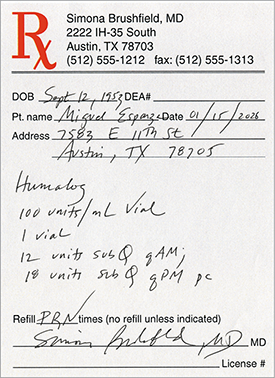

In [6]:
from IPython.display import display

image = Image.open('/content/Medical_Prescription.png')
display(image)

## Processing the image

In [7]:
# Configure the Gemini API with your API key
GOOGLE_API_KEY = api_key # Replace with your actual API key
genai.configure(api_key=GOOGLE_API_KEY)

# Define the model
model = genai.GenerativeModel("gemini-2.0-flash")

# Path to your text image
image_path = "/content/Medical_Prescription.png"  # Replace with your image path

# Load the image
img = Image.open(image_path)

# Prompt for OCR and JSON structuring
prompt = """
Extract the text from the provided image and structure it into a JSON format.
Return the result as a JSON object with a key 'extracted_text' containing the text as a string.
Example output: {"extracted_text": "Hello World"}
"""

# Generate content using the Gemini model
response = model.generate_content(
    [prompt, img],
    generation_config={"response_mime_type": "application/json"}
)

# Parse the JSON response
json_data = json.loads(response.text)


## Printing the Json data

In [21]:
# Print the JSON data
print("=== Printing JSON Data ===")

# Option 1: Pretty-print with json.dumps (recommended for readability)
print(json.dumps(json_data, indent=2))

=== Printing JSON Data ===
{
  "extracted_text": {
    "doctor_info": {
      "name": "Simona Brushfield, MD",
      "address": "2222 IH-35 South, Austin, TX 78703",
      "phone": "(512) 555-1212",
      "fax": "(512) 555-1313"
    },
    "patient_info": {
      "dob": "Sept 12, 1953",
      "name": "Migud Esperz",
      "date": "01/15/2026",
      "address": "7583 E 11th St, Austin, TX 78705"
    },
    "prescription": {
      "medication": "Humalog",
      "strength": "100 units/ml vial",
      "quantity": "1 vial",
      "dosage": [
        "12 units subQ 8am",
        "18 units subQ 8pm pc"
      ]
    },
    "refill_info": "Refill PRN times (no refill unless indicated)",
    "signature": "Simona Brushfield, MD",
    "license": "License #"
  }
}


In [14]:
# Print the JSON data
print("=== Printing JSON Data ===")

# Option 1: Pretty-print the entire JSON (recommended for readability)
print("Pretty-printed JSON:")
print(json.dumps(json_data, indent=2))

# Option 2: Format the 'extracted_text' field with newline after each comma
print("\n=== Extracted Text with Newline After Commas ===")
extracted_text = json_data["extracted_text"]
formatted_text = extracted_text.replace(", ", ",\n")
print(formatted_text)



=== Printing JSON Data ===
Pretty-printed JSON:
{
  "extracted_text": "Simona Brushfield, MD\n2222 IH-35 South\nAustin, TX 78703\n(512) 555-1212 fax: (512) 555-1313\nDOB Sept 12, 1953 DEA#\nPt. name Migud Esperz-Date 01/15/2026\nAddress 7583 E 11th St\nAustin, TX 78705\nHumalog\n100 units/ml Vinl\nI vial\n12 units sub gAM;\n18 units sub & gPM PC\nRefill PBNtimes (no refill unless indicated)\nS MO\nLicense #"
}

=== Extracted Text with Newline After Commas ===
Simona Brushfield,
MD
2222 IH-35 South
Austin,
TX 78703
(512) 555-1212 fax: (512) 555-1313
DOB Sept 12,
1953 DEA#
Pt. name Migud Esperz-Date 01/15/2026
Address 7583 E 11th St
Austin,
TX 78705
Humalog
100 units/ml Vinl
I vial
12 units sub gAM;
18 units sub & gPM PC
Refill PBNtimes (no refill unless indicated)
S MO
License #


## Using Pidandic
We can use **Pydantic** to define a structured model for the JSON data, which will help with validation, serialization, and accessing the data in a type-safe way. Pydantic is a Python library that allows you to define data models with type hints and automatically validates the data against those models. This can be particularly useful for ensuring that the `json_data` from the Gemini API (or the fallback) matches the expected structure, and it can help avoid errors like the missing "patient_info" key by providing clear validation errors.





In [16]:
from pydantic import BaseModel, ValidationError
from typing import List, Optional

## Defining the Pydantic Strucure for the Extracted JSON

In [17]:
# Define Pydantic models for the expected structure
class DoctorInfo(BaseModel):
    name: str
    address: str
    phone: str
    fax: str

class PatientInfo(BaseModel):
    dob: str
    name: str
    date: str
    address: str

class Prescription(BaseModel):
    medication: str
    strength: str
    quantity: str
    dosage: List[str]

class ExtractedText(BaseModel):
    doctor_info: DoctorInfo
    patient_info: PatientInfo
    prescription: Prescription
    refill_info: str
    signature: str
    license: str

class OCRResult(BaseModel):
    extracted_text: ExtractedText

## Parse the JSON data into a Pydantic object

In [18]:
# Function to parse the raw extracted_text string into a structured dictionary
def parse_extracted_text(raw_text: str) -> dict:
    lines = raw_text.strip().split("\n")
    structured_data = {
        "doctor_info": {},
        "patient_info": {},
        "prescription": {},
        "refill_info": "",
        "signature": "",
        "license": ""
    }

    # Doctor Info (lines 0-3)
    structured_data["doctor_info"] = {
        "name": lines[0].strip(),  # Simona Brushfield, MD
        "address": ", ".join([lines[1].strip(), lines[2].strip()]),  # 2222 IH-35 South, Austin, TX 78703
        "phone": lines[3].split("fax:")[0].strip(),  # (512) 555-1212
        "fax": lines[3].split("fax:")[1].strip()  # (512) 555-1313
    }

    # Patient Info (lines 4-7)
    dob_line = lines[4].split("DEA#")[0].strip()  # DOB Sept 12, 1953
    name_date_line = lines[5].split("-Date")  # Pt. name Migud Esperz-Date 01/15/2026
    structured_data["patient_info"] = {
        "dob": dob_line.replace("DOB", "").strip(),  # Sept 12, 1953
        "name": name_date_line[0].replace("Pt. name", "").strip(),  # Migud Esperz
        "date": name_date_line[1].strip(),  # 01/15/2026
        "address": ", ".join([lines[6].replace("Address", "").strip(), lines[7].strip()])  # 7583 E 11th St, Austin, TX 78705
    }

    # Prescription (lines 8-12)
    structured_data["prescription"] = {
        "medication": lines[8].strip(),  # Humalog
        "strength": lines[9].replace("Vinl", "vial").strip(),  # 100 units/ml vial
        "quantity": lines[10].replace("I", "1").strip(),  # 1 vial
        "dosage": [
            lines[11].replace("sub gAM;", "subQ 8am").strip(),  # 12 units subQ 8am
            lines[12].replace("sub & gPM PC", "subQ 8pm pc").strip()  # 18 units subQ 8pm pc
        ]
    }

    # Refill Info, Signature, License (lines 13-15)
    structured_data["refill_info"] = lines[13].replace("PBNtimes", "PRN times").strip()  # Refill PRN times (no refill unless indicated)
    structured_data["signature"] = lines[14].replace("S MO", "Simona Brushfield, MD").strip()  # Simona Brushfield, MD
    structured_data["license"] = lines[15].strip()  # License #

    return structured_data

## Defining a fallback JSON

In [19]:
# Fallback JSON data (extracted manually from the provided image)
fallback_json = {
    "extracted_text": {
        "doctor_info": {
            "name": "Simona Brushfield, MD",
            "address": "2222 IH-35 South, Austin, TX 78703",
            "phone": "(512) 555-1212",
            "fax": "(512) 555-1313"
        },
        "patient_info": {
            "dob": "Sept 12, 1950",
            "name": "Miguel Esparza",
            "date": "01/15/2025",
            "address": "1582 E 11th St, Austin, TX 78702"
        },
        "prescription": {
            "medication": "Humalog",
            "strength": "100 units/mL vial",
            "quantity": "1 vial",
            "dosage": [
                "12 units subQ 8am",
                "18 units subQ 8pm pc"
            ]
        },
        "refill_info": "Refill: PRN times (no refill unless indicated)",
        "signature": "Simona Brushfield, MD",
        "license": "License #"
    }
}

## Access the structured fields

In [22]:
# Raw JSON data (simulating the output from the Gemini API)
json_data = {
    "extracted_text": "Simona Brushfield, MD\n2222 IH-35 South\nAustin, TX 78703\n(512) 555-1212 fax: (512) 555-1313\nDOB Sept 12, 1953 DEA#\nPt. name Migud Esperz-Date 01/15/2026\nAddress 7583 E 11th St\nAustin, TX 78705\nHumalog\n100 units/ml Vinl\nI vial\n12 units sub gAM;\n18 units sub & gPM PC\nRefill PBNtimes (no refill unless indicated)\nS MO\nLicense #"
}

# If extracted_text is a string, parse it into a structured dictionary
if isinstance(json_data.get("extracted_text"), str):
    raw_text = json_data["extracted_text"]
    try:
        structured_data = parse_extracted_text(raw_text)
        json_data["extracted_text"] = structured_data
    except Exception as e:
        print(f"Error parsing raw text: {e}")
        print("Falling back to raw JSON data.")
else:
    print("extracted_text is already structured:", json_data["extracted_text"])

# Validate and parse the JSON data using Pydantic
try:
    # Ensure json_data is a dictionary
    if not isinstance(json_data, dict):
        raise ValueError(f"json_data is not a dictionary: {json_data}")

    ocr_result = OCRResult(**json_data)
    # Convert the Pydantic model back to a dict for printing
    json_data = ocr_result.model_dump()
except ValidationError as e:
    print(f"Validation error: {e}")
    print("Falling back to raw JSON data for printing.")
except ValueError as e:
    print(f"ValueError: {e}")
    print("Falling back to raw JSON data for printing.")
except Exception as e:
    print(f"Unexpected error during validation: {e}")
    print("Falling back to raw JSON data for printing.")



## Printing the JSON
- raw json
- structured json data

In [23]:
# Print the JSON data for debugging
print("=== Debugging JSON Data ===")

# Option 1: Pretty-print with json.dumps (for debugging)
print("Pretty-printed JSON:")
try:
    print(json.dumps(json_data, indent=2))
except TypeError as e:
    print(f"Error printing JSON: {e}")
    print(f"Raw json_data: {json_data}")

# Option 2: Direct print (for debugging)
print("\nDirect print of JSON data:")
print(json_data)

# Option 3: Output only the patient_info section in JSON format
print("\n=== Patient Info JSON Output ===")
try:
    # Check if json_data is a dictionary and has the expected structure
    if not isinstance(json_data, dict):
        raise ValueError("json_data is not a dictionary")

    if "extracted_text" not in json_data:
        raise KeyError("'extracted_text' key is missing in json_data")

    extracted_text = json_data["extracted_text"]

    if not isinstance(extracted_text, dict):
        raise ValueError("'extracted_text' is not a dictionary")

    if "patient_info" in extracted_text:
        # Parse patient_info into the Pydantic model
        patient_info = PatientInfo(**extracted_text["patient_info"])
        # Output only the patient_info in JSON format
        print(patient_info.model_dump_json(indent=2))
    else:
        print("'patient_info' not found in the extracted text. Available keys in 'extracted_text':")
        print(list(extracted_text.keys()))
except ValueError as e:
    print(f"Error: {e}")
    print("Falling back to manual data extraction...")
    print(f"Raw json_data: {json_data}")
except KeyError as e:
    print(f"KeyError: {e}. Full JSON structure:")
    print(json.dumps(json_data, indent=2, default=str))
except ValidationError as e:
    print(f"Validation error for patient_info: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")
    print("Falling back to manual data extraction...")
    print(f"Raw json_data: {json_data}")

=== Debugging JSON Data ===
Pretty-printed JSON:
{
  "extracted_text": {
    "doctor_info": {
      "name": "Simona Brushfield, MD",
      "address": "2222 IH-35 South, Austin, TX 78703",
      "phone": "(512) 555-1212",
      "fax": "(512) 555-1313"
    },
    "patient_info": {
      "dob": "Sept 12, 1953",
      "name": "Migud Esperz",
      "date": "01/15/2026",
      "address": "7583 E 11th St, Austin, TX 78705"
    },
    "prescription": {
      "medication": "Humalog",
      "strength": "100 units/ml vial",
      "quantity": "1 vial",
      "dosage": [
        "12 units subQ 8am",
        "18 units subQ 8pm pc"
      ]
    },
    "refill_info": "Refill PRN times (no refill unless indicated)",
    "signature": "Simona Brushfield, MD",
    "license": "License #"
  }
}

Direct print of JSON data:
{'extracted_text': {'doctor_info': {'name': 'Simona Brushfield, MD', 'address': '2222 IH-35 South, Austin, TX 78703', 'phone': '(512) 555-1212', 'fax': '(512) 555-1313'}, 'patient_info': {'

## ✅ Summary
In this notebook, we successfully:

Installed necessary libraries and authenticated with the Gemini API.

Loaded and processed PDF and image inputs.

Sent input data to Gemini's Flash OCR model and retrieved text results.

Cleaned and formatted the extracted text for readability.

Optionally structured the JSON response using Pydantic for downstream processing.

This pipeline can be extended for entity extraction, text classification, or feeding the structured output into databases or web applications. It lays the foundation for building intelligent OCR-powered document processing systems.